### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [42]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))
import xgboost
print("xgboost: {}".format(xgboost.__version__))

Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
pandas version: 2.2.2
matplotlib version: 3.8.4
NumPy version: 1.26.4
SciPy version: 1.13.0
IPython version: 8.23.0
scikit-learn version: 1.4.2
seaborn version: 0.13.2
xgboost: 2.0.3


#### Importing the dataset

In [43]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
# Keep in mind that the file is encoded in UTF-8 so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")


Before pre-processing the dataset has 45 columns and 305434 rows


dropp kommentarer. except for tekniske ting
vise dataen underveis
dropna, påstander om hvorfor vi dropper de, bevis 
vise distribusjon av outliers
fillNA, groupBy, meldingsid, startstidspunkt
robustScaler, hvorfor vi bruker det, outliers
scalingData for modellene, forklar
gradientBoosting, scaling data hvorfor? Bedre optimum, forklare MultioutputRegressor
MLPR, not converging, learning rate importances
viktig train validation og test splits,
forklare typene features, 
skaleringen fit skal bare være på treningsdataen, skalering skal kun være minste og største verdiene i treningsdataen. 
scaler.fit()transform på treningsdataen
validationset ikke hellig, testdata = helt skjult frem til eksamen.
scaler.fit på testset

#### Choosing target and pre-prossesing
After taking some time to understand the data we have chosen our target features to be the catches of Hyse, Torsk and Sei as continuous values. Next we will pre-prosess the data so it is ready for modeling.

In [44]:
# Using the same seed for testing purposes makes the results more comparable
seed = 32

In [45]:
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


In [46]:
# Excluding irrelevant columns

# Fangstår has only 2 unique values
df.drop(columns = ['Fangstår'], inplace= True)

# Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde all seem to be speaking of the boat doing the catching, with few unique values in each column.
# One of them should be kept as a feature, the rest discarded. We would suggest the most relevant to be Bruttotonasje, which speaks to how much cargo space there is.
# "Bruttotonnasje 1969" and "Bruttotonnasje annen" seem to have nan where the other one has a value, so first we will collapse them into one.
df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969","Lengdegruppe (kode)", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)

# All columns (kode) in them are cateogrical code representations of another column. For human-readability and to avoid mistaking the code for a continuous value we will remove them.
df.drop(columns=["Hovedområde start (kode)", "Lokasjon start (kode)", "Hovedområde stopp (kode)", "Lokasjon stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)", "Hovedart - FDIR (kode)", "Art FAO (kode)", "Art - FDIR (kode)", "Art - gruppe (kode)", ], inplace = True)

# In both the "Redskap" and "Art" columns you have FAO and FDIR abbriviations. FAO = Food and Agriculture Organization of the United Nations and FDIR = Fiskeridirektoratet
# Due to "Hovedart" onyl having FAO uncoded we will stick to FAO. For the same reason we will remove "Art - gruppe"
df.drop(columns=["Art - gruppe", "Art - FDIR", "Redskap FDIR"], inplace=True)

# The areas where they start and stop have 6 columns. A pair of coordiantes and name of area x2. Since we prefer the continuous features and coordinates=name of place we are removing the name.
df.drop(columns=["Hovedområde start", "Hovedområde stopp"], inplace=True)

# While time of day and date might be relevant we don't need all of them and we don't need to know when it was reported in. For now we will leave start/end date and time.
df.drop(columns=["Meldingsdato", "Meldingsklokkeslett", "Stopptidspunkt"], inplace=True)

# After trying to transform the remaining time columns into continuous values we could use they seemed to have no other effect on the result then longer prosessing time.
# df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)

In [47]:
df.head()

,Melding ID,Meldingstidspunkt,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Art FAO,Rundvekt,Bruttotonnasje
0,1497177,01.01.2018,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",-2740,01.01.2018,00:00,1440,"-60,4","-46,15",-805,5649.0,"Flytetrål, otter",Antarktisk krill,Antarktisk krill,706714.0,9432.0
1,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Hyse,9594.0,1476.0
2,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Torsk,8510.0,1476.0
3,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Blåkveite,196.0,1476.0
4,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Sei,134.0,1476.0


In [48]:
# After having checked to see what % of each column had nan values we decided just to drop them as at worst they were around 1.6 %
df.shape
df = df.dropna()
df.shape
df.head()

,Melding ID,Meldingstidspunkt,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Art FAO,Rundvekt,Bruttotonnasje
0,1497177,01.01.2018,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",-2740,01.01.2018,00:00,1440,"-60,4","-46,15",-805,5649.0,"Flytetrål, otter",Antarktisk krill,Antarktisk krill,706714.0,9432.0
1,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Hyse,9594.0,1476.0
2,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Torsk,8510.0,1476.0
3,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Blåkveite,196.0,1476.0
4,1497178,01.01.2018,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,Sei,134.0,1476.0


In [49]:
# Focusing down on the species we want to investigate
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [50]:
# Removing parts of columns

# From varighet we remove anyting above 400 as according to lecturer that is in the high range of how long you would be fishing in a session.
# So we will consider them outliers or multiple sessions reported as one and exclude them for now.

df = df[df['Varighet'] <= 400]

# Removing outliers from "Trekkavstand" as above 50000 the frequency gets 100 instances per 5000 length.
df = df[df['Trekkavstand'] <= 50000]

In [51]:
# Manipulating columns

# The coordinates are strings, changing them to int for easier use.
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '').astype(int)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '').astype(int)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '').astype(int)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '').astype(int)

df['Trekkavstand'] = df['Trekkavstand'].astype(int)
df['Bruttotonnasje'] = df['Bruttotonnasje'].astype(int)
df['Varighet'] = df['Varighet'].astype(int)
# df['Startmåned'] = df['Startdato'].astype(str).str[3:5]
# df['Starttime'] = df['Startklokkeslett'].astype(str).str[3:5]
# df['Stoppmåned'] = df['Stoppdato'].astype(str).str[3:5]
# df['Stopptime'] = df['Stoppklokkeslett'].astype(str).str[3:5]
df.drop(columns=['Startdato', "Startklokkeslett", "Stoppdato", "Stoppklokkeslett"], inplace=True)
# Many of the sea depth notations are positiv, which doesn't make sense.
# But the amount of them in relation to number of entries means it can't be discounted as an error
# In the lecture on fisheries it was mentioned that a lot fo these are inputed manually
# And that most of these non-sensical sea depths are actually correct, just lacking a minus.
# Therefore we are simply flipping all the positive sea depth into negatives.
df['Havdybde start'] = -df['Havdybde start'].abs()
df['Havdybde stopp'] = -df['Havdybde stopp'].abs()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108619 entries, 1 to 305428
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Melding ID            108619 non-null  int64  
 1   Meldingstidspunkt     108619 non-null  object 
 2   Starttidspunkt        108619 non-null  object 
 3   Startposisjon bredde  108619 non-null  int32  
 4   Startposisjon lengde  108619 non-null  int32  
 5   Havdybde start        108619 non-null  int64  
 6   Varighet              108619 non-null  int32  
 7   Stopposisjon bredde   108619 non-null  int32  
 8   Stopposisjon lengde   108619 non-null  int32  
 9   Havdybde stopp        108619 non-null  int64  
 10  Trekkavstand          108619 non-null  int32  
 11  Redskap FAO           108619 non-null  object 
 12  Hovedart FAO          108619 non-null  object 
 13  Art FAO               108619 non-null  object 
 14  Rundvekt              108619 non-null  float64
 15  Brutt

Art FAO
Torsk    43757
Sei      32988
Hyse     31874
Name: count, dtype: int64


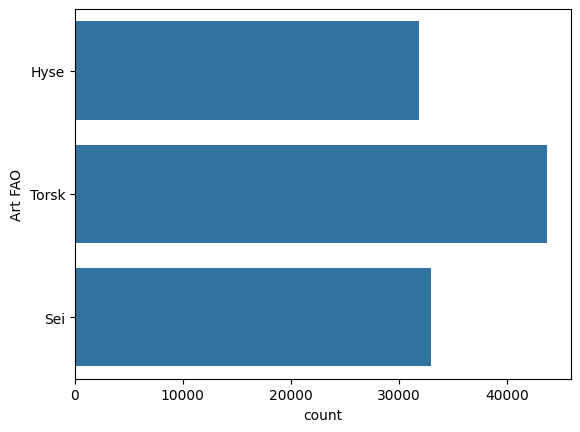

In [52]:
#counting species
print(df['Art FAO'].value_counts())
#plotting species
sns.countplot(df['Art FAO'])
plt.show()

In [53]:
# Pivoting table

# Pivoting table so rows that are information about the same session are put together
print(f"Before pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df = df.pivot_table(index=['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde',
                           'Havdybde start', 'Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand',
                            'Redskap FAO','Hovedart FAO','Bruttotonnasje' ], columns='Art FAO', values='Rundvekt', aggfunc='sum').reset_index()
# # This creates a lot of nan values which we fill with 0
df.info()
# df.dropna(inplace=True)
df.fillna(0, inplace=True)
df.info()


Before pre-processing the dataset has 16 columns and 108619 rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51075 entries, 0 to 51074
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Melding ID            51075 non-null  int64  
 1   Startposisjon bredde  51075 non-null  int32  
 2   Startposisjon lengde  51075 non-null  int32  
 3   Havdybde start        51075 non-null  int64  
 4   Varighet              51075 non-null  int32  
 5   Stopposisjon bredde   51075 non-null  int32  
 6   Stopposisjon lengde   51075 non-null  int32  
 7   Havdybde stopp        51075 non-null  int64  
 8   Trekkavstand          51075 non-null  int32  
 9   Redskap FAO           51075 non-null  object 
 10  Hovedart FAO          51075 non-null  object 
 11  Bruttotonnasje        51075 non-null  int32  
 12  Hyse                  31868 non-null  float64
 13  Sei                   32983 non-null  float64
 14  Torsk

In [54]:
#counting the dropped values after processing
print(f"After pre-processing the dataset has {df.shape[1]} columns and {df.shape[0]} rows")
df.head()

After pre-processing the dataset has 15 columns and 51075 rows


Art FAO,Melding ID,Startposisjon bredde,Startposisjon lengde,Havdybde start,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Hovedart FAO,Bruttotonnasje,Hyse,Sei,Torsk
0,1497178,7491,15868,-403,267,74901,16248,-277,11096,"Bunntrål, otter",Hyse,1476,9118.0,67.0,6651.0
1,1497178,74883,16056,-346,315,74924,15742,-496,10215,"Bunntrål, otter",Hyse,1476,12432.0,68.0,5097.0
2,1497178,74885,16048,-335,295,74914,15969,-334,3970,"Bunntrål, otter",Hyse,1476,9594.0,134.0,8510.0
3,1497178,74931,15785,-443,243,74926,15894,-358,3214,"Bunntrål, otter",Torsk,1476,6758.0,0.0,7022.0
4,1497229,67826,12967,-71,72,67829,12933,-54,1471,Snurrevad,Torsk,51,0.0,0.0,1800.0


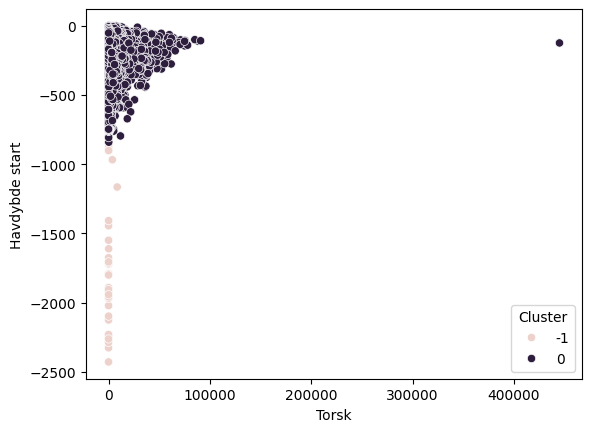

In [55]:
# #dbscan for clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# clustering based on coordinates
coords = df[['Havdybde start', 'Havdybde stopp']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(coords_scaled)
df['Cluster'] = dbscan.labels_

#plotting clusters
sns.scatterplot(data=df, x='Torsk', y='Havdybde start', hue='Cluster')
plt.show()

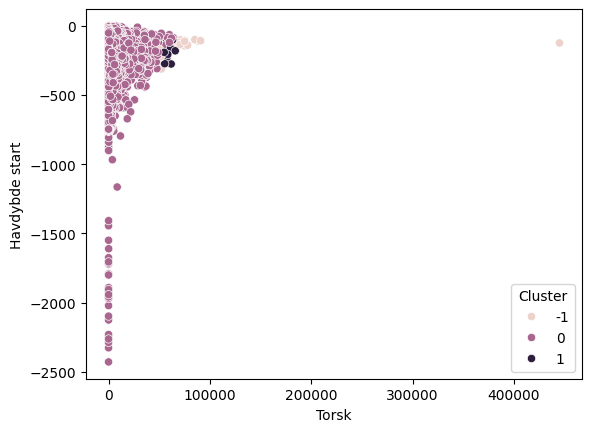

In [71]:
# #dbscan for clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# clustering based on coordinates
coords = df[['Bruttotonnasje', 'Torsk']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(coords_scaled)
df['Cluster'] = dbscan.labels_

#plotting clusters
sns.scatterplot(data=df, x='Torsk', y='Havdybde start', hue='Cluster')
plt.show()

In [ ]:
#using kmeans
from sklearn.cluster import KMeans
import numpy as np


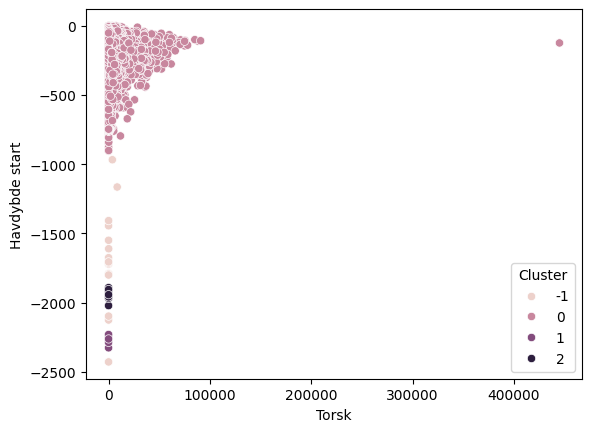

In [67]:
# #dbscan for clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# clustering based on coordinates
coords = df[['Sei', 'Havdybde start']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(coords_scaled)
df['Cluster'] = dbscan.labels_

#plotting clusters
sns.scatterplot(data=df, x='Torsk', y='Havdybde start', hue='Cluster')
plt.show()

In [56]:
# Scaling and one-hot encoding features
#importing minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# Scale the numerical features. During testing of the models it seemed to have little to no difference for the random forest model.
# But we keep them this way in case other models find them useful.
num_feat = df[['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
        'Varighet','Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(num_feat)
scaled_df = pd.DataFrame(scaled_features, columns=num_feat.columns)

In [57]:
# One-hot encode the categorical features. 
from sklearn.preprocessing import OneHotEncoder
cat_feat = df[["Redskap FAO", 'Hovedart FAO']]
encoder = OneHotEncoder()
enc_feat= encoder.fit_transform(cat_feat)
enc_df = pd.DataFrame(enc_feat.toarray(), columns=encoder.get_feature_names_out())

# Concatonate the changed features
features = pd.concat([enc_df, scaled_df], axis=1)
# Isolate the targets
targets = df[['Hyse', 'Sei', 'Torsk']]

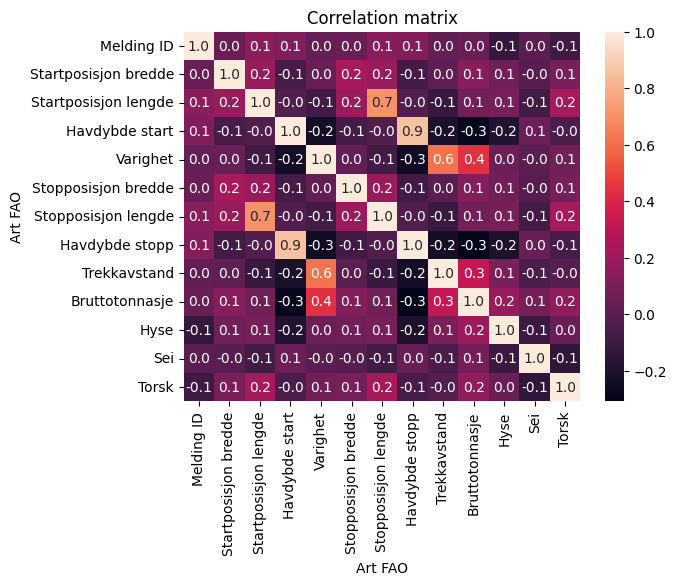

In [58]:
df_corr = df[['Melding ID', 'Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start','Varighet', 'Stopposisjon bredde', 'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Bruttotonnasje', 'Hyse', 'Sei', 'Torsk']]
#plotting the correlation matrix
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f" )  #.1ft for using one decimal
plt.title('Correlation matrix')
plt.show() #the correlation matrix does not really tell us any strong relationships between relevant features. The non-linear relationships could still be useful for the model though.

#### Testing models and further exploration of data

Because decision trees are good when there is a different mix of features we have decided to use random forest to even out the downsides of single decision trees. As en extension of that we have decided to use a gradient boosting model as our second model.

##### Baseline RandomForestRegressor

In [59]:
#using random forest without optimization for creating a baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(scaled_df, targets, test_size=0.02, random_state=seed)
rfr = RandomForestRegressor(n_estimators=250, max_features=25, max_depth=40)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}, RMSE: {rmse}.")

R2: 0.5888534879800131, RMSE: 4120.919076873964.


##### RandomForestRegressor with encoded values + scaled

In [65]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

# After testing various parameters we chose to go with n_estimators=200, max_features=25, max_depth=40 for this dataset
# The features seemed to be best from 20 upwards. Depth was best between 25-40, from 45 it seemed to go down in performance befroe picking it up again at 70.
# We only tested up to 300 estimators, and it seemed to increase performance slightly all the way up, but for running time we are currently using 200.
rfr = RandomForestRegressor(n_estimators=250, max_features=87, max_depth=50)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_oneHot = r2_score(y_test, y_pred)
print(f"R2: {r2_oneHot}, RMSE: {rmse}.")

R2: 0.6336851895452155, RMSE: 3962.3793090374033.


(51075, 83)

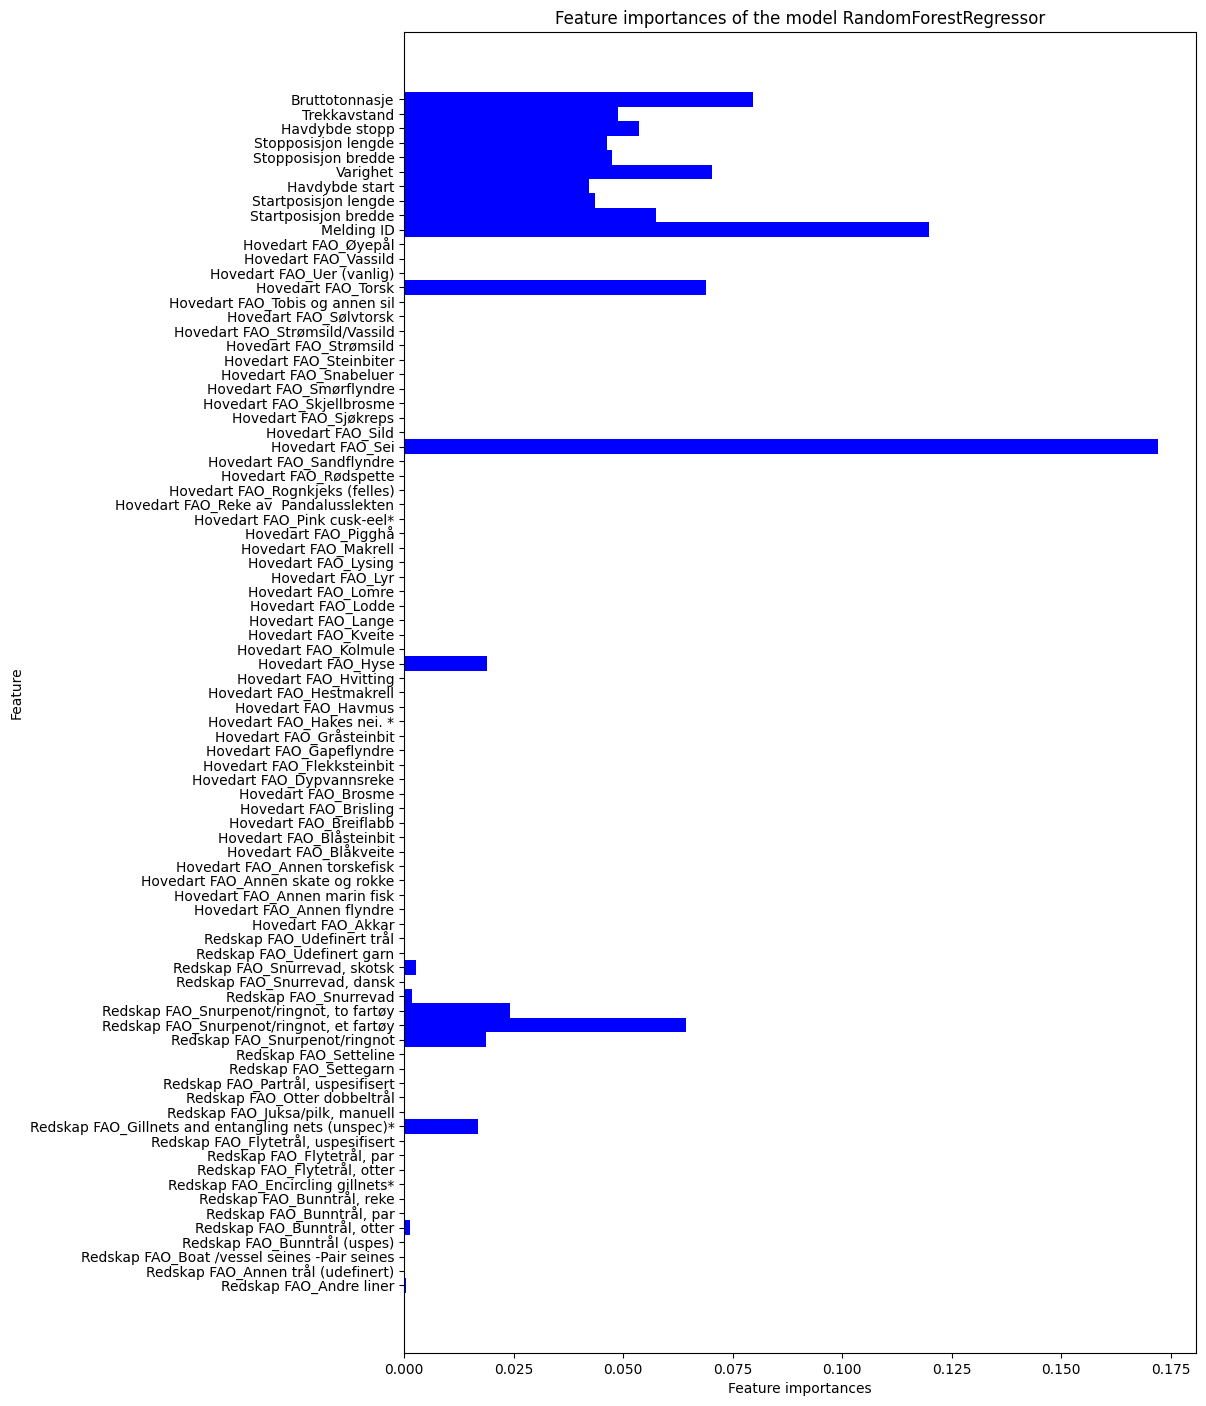

In [61]:

def plot_feature_importances(model, feature_columns):
    n_features = len(feature_columns.columns)
    feature_indices = feature_columns.columns.tolist()
    feature_importances = model.feature_importances_
    #adding if statement to remove the one-hot encoded columns that have no importance



    fig = plt.figure(figsize=(12,14))
    plt.subplot(111)
    plt.barh(range(n_features), feature_importances, height=1, color='b', align='center')
    plt.yticks(np.arange(n_features), feature_indices[:n_features])
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")
    plt.title("Feature importances of the model {}".format(model.__class__.__name__))
    plt.tight_layout(pad=0.5)
plot_feature_importances(rfr, features)


features.shape
# This graph shows the feature importance of the randomforest model.
# A lot of the one-hot encoded features seem to have no importance. We tried collapsing all the seemingly irrelevant ones into a single column.
# That seemed to worsen the R2 score from 0.637-642 to around 0.44 so we've decided to keep them for now even though this graph seems to indicate their lack of importance.

##### GradientBoostingRegressor with encoded + scaled values


In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
# From testing: putting the learning rate at 0.3 or above seems to make results worse. Setting depth over 10 seems to do the same and increase the runtime a lot.
# We will do some more rounds of testing, but for now are settling on a depth of 7, learning rate of 0.8. Number of estimators hasent been tested yet, so for now its a standard of 100.

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

base_estimator = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=seed)
        
multioutput_regressor = MultiOutputRegressor(base_estimator)
        
multioutput_regressor.fit(X_train, y_train)
        
y_pred = multioutput_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_gradient = r2_score(y_test, y_pred)
print(f"R2: {r2_gradient}, RMSE: {rmse}.")

# Their is certainly room for combing other gradient boosting techqniues, such as XGBoost, LightGBM or CatBoost with the randomforest model.

R2: 0.6278648527666671, RMSE: 3990.8053217519714.


In [63]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# #using XG boost with encoded + scaled features
# # Split the data into training and testing sets
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

# X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

# # Instantiate the XGBRegressor: xg_reg
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
#                 max_depth = 40, alpha = 10, n_estimators = 200, )

# # Fit the regressor to the training set
# xg_reg.fit(X_train, y_train)

# # Predict the labels of the test set: preds
# preds = xg_reg.predict(X_test)

# # Compute the rmse: rmse
# rmse = np.sqrt(mean_squared_error(y_test, preds))
# r2_xg = r2_score(y_test, preds)
# print(f"R2: {r2_xg}, RMSE: {rmse}.")

In [64]:
#Decided to use the MLPRegressor model as the deep learning model, since it is the most relevant for our regression problem. Using one hot encoded values, continuous values and scaled values. 
from sklearn.neural_network import MLPRegressor
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)
#creating the model
model = MLPRegressor(random_state=seed, max_iter=1000, verbose=True, hidden_layer_sizes=(100, 50, 25, 10), activation='relu', solver='adam', batch_size='auto', learning_rate='adaptive', learning_rate_init=0.02,shuffle=True,  early_stopping=False)
model.fit(X_train, y_train)
#currently in testing phase of understanding and using the correct parameters for the model.
#predicting the test data
y_pred = model.predict(X_test)
print(y_pred.round(2))
#returning the result
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean squared error: {rmse}")
#r2 score
r2_mlp = r2_score(y_test, y_pred)
print(f"R2 score: {r2_mlp}")

Iteration 1, loss = 18058504.38223000
Iteration 2, loss = 12767647.32562348
Iteration 3, loss = 11923169.61206242
Iteration 4, loss = 11787799.54039775
Iteration 5, loss = 11416367.08887844
Iteration 6, loss = 10499495.34337781
Iteration 7, loss = 10290218.90191625
Iteration 8, loss = 10063890.03682317
Iteration 9, loss = 9982755.99882235
Iteration 10, loss = 9787055.32400608
Iteration 11, loss = 9742116.42002117
Iteration 12, loss = 9525190.76104365
Iteration 13, loss = 9442435.89410950
Iteration 14, loss = 9375896.84913646
Iteration 15, loss = 9292030.18494404
Iteration 16, loss = 9267696.22490013
Iteration 17, loss = 9248628.35577152
Iteration 18, loss = 9252493.13959660
Iteration 19, loss = 9180045.76936224
Iteration 20, loss = 9242092.38842301
Iteration 21, loss = 9116375.33857998
Iteration 22, loss = 9164259.15888107
Iteration 23, loss = 9168138.83237752
Iteration 24, loss = 9122238.39759021
Iteration 25, loss = 9150922.59814180
Iteration 26, loss = 9063661.15223035
Iteration 27,

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=seed)

# # Create polynomial features
# poly = PolynomialFeatures(degree=4)  # You can adjust the degree as needed
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)

# # Fit the linear regression model on the polynomial features
# model = LinearRegression()
# model.fit(X_train_poly, y_train)

# # Predict on the test set
# y_pred = model.predict(X_test_poly)

# # Calculate RMSE and R2 score
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2_poly = r2_score(y_test, y_pred)

# print(f"Root Mean Squared Error: {rmse}")
# print(f"R2 Score: {r2_poly}")


Text(0.5, 1.0, 'R2 scores of the models')

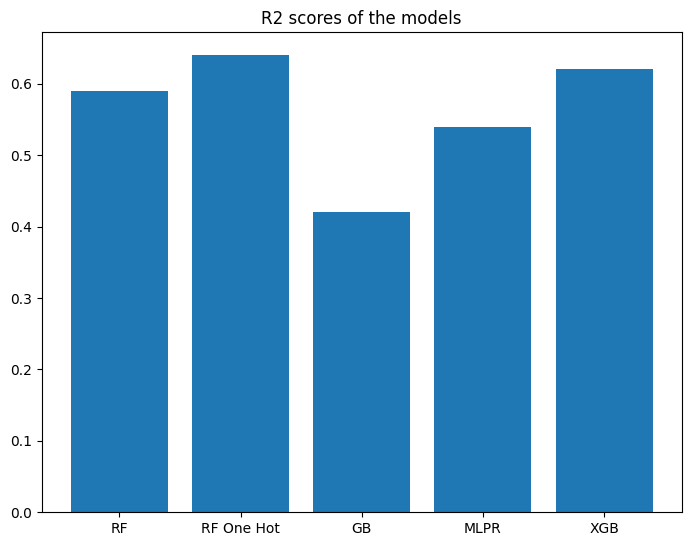

In [ ]:
#plotting all the r2 scores from each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['RF','RF One Hot', 'GB', 'MLPR', 'XGB']
r2_scores = [0.59,0.64, 0.42, 0.54, 0.62]
ax.bar(models,r2_scores)
plt.title('R2 scores of the models')

##### This function is for keeping track of the models we have tested and their scores

In [ ]:
def result():
    with open('results.txt', 'w') as f:
        f.write(f"Multioutputregression: {r2_mlp}\n")
        f.write(f"RandomForest Baseline: {r2}\n")
        f.write(f"GradientBoosting: {r2_gradient}\n")
        f.write(f"RandomForest One Hot: {r2_oneHot}\n") 
        # f.write(f"XGBoost: {r2_xg}\n")
result()

NameError: name 'r2_xg' is not defined

##### Creating our own deep learning model with pytorch

In [ ]:
# -*- coding: utf-8 -*-
# import torch
# import math


# # Create Tensors to hold input and outputs.
# x = torch.linspace(-math.pi, math.pi, 2000)
# y = torch.sin(x)

# # For this example, the output y is a linear function of (x, x^2, x^3), so
# # we can consider it as a linear layer neural network. Let's prepare the
# # tensor (x, x^2, x^3).
# p = torch.tensor([1, 2, 3])
# xx = x.unsqueeze(-1).pow(p)

# # In the above code, x.unsqueeze(-1) has shape (2000, 1), and p has shape
# # (3,), for this case, broadcasting semantics will apply to obtain a tensor
# # of shape (2000, 3) 

# # Use the nn package to define our model as a sequence of layers. nn.Sequential
# # is a Module which contains other Modules, and applies them in sequence to
# # produce its output. The Linear Module computes output from input using a
# # linear function, and holds internal Tensors for its weight and bias.
# # The Flatten layer flatens the output of the linear layer to a 1D tensor,
# # to match the shape of `y`.
# model = torch.nn.Sequential(
#     torch.nn.Linear(3, 1),
#     torch.nn.Flatten(0, 1)
# )
# # The nn package also contains definitions of popular loss functions; in this
# # case we will use Mean Squared Error (MSE) as our loss function.
# loss_fn = torch.nn.MSELoss(reduction='sum')

# learning_rate = 1e-6
# for t in range(2000):

#     # Forward pass: compute predicted y by passing x to the model. Module objects
#     # override the __call__ operator so you can call them like functions. When
#     # doing so you pass a Tensor of input data to the Module and it produces
#     # a Tensor of output data.
#     y_pred = model(xx)

#     # Compute and print loss. We pass Tensors containing the predicted and true
#     # values of y, and the loss function returns a Tensor containing the
#     # loss.
#     loss = loss_fn(y_pred, y)
#     if t % 100 == 99:
#         print(t, loss.item())

#     # Zero the gradients before running the backward pass.
#     model.zero_grad()

#     # Backward pass: compute gradient of the loss with respect to all the learnable
#     # parameters of the model. Internally, the parameters of each Module are stored
#     # in Tensors with requires_grad=True, so this call will compute gradients for
#     # all learnable parameters in the model.
#     loss.backward()

#     # Update the weights using gradient descent. Each parameter is a Tensor, so
#     # we can access its gradients like we did before.
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= learning_rate * param.grad

# # You can access the first layer of `model` like accessing the first item of a list
# linear_layer = model[0]

# # For linear layer, its parameters are stored as `weight` and `bias`.
# print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 577.6156005859375
199 391.6925964355469
299 266.7757873535156
399 182.7763671875
499 126.24249267578125
599 88.15926361083984
699 62.48145294189453
799 45.1513671875
899 33.443695068359375
999 25.526470184326172
1099 20.166912078857422
1199 16.534988403320312
1299 14.071144104003906
1399 12.397944450378418
1499 11.260356903076172
1599 10.48609447479248
1699 9.958520889282227
1799 9.598614692687988
1899 9.352811813354492
1999 9.18474006652832
Result: y = -0.015121880918741226 + 0.8443120718002319 x + 0.0026087758596986532 x^2 + -0.09156250208616257 x^3


dropp kommentarer. except for tekniske ting
vise dataen underveis
dropna, påstander om hvorfor vi dropper de, bevis 
vise distribusjon av outliers
fillNA, groupBy, meldingsid, startstidspunkt
robustScaler, hvorfor vi bruker det, outliers
scalingData for modellene, forklar
gradientBoosting, scaling data hvorfor? Bedre optimum, forklare MultioutputRegressor







